# Рекуррентные нейронные сети

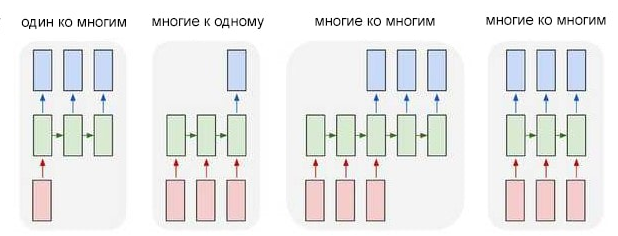

In [ ]:
import torch
from torch import nn
from torch import optim

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Классификация текста

In [ ]:
!pip install razdel pymorphy2

In [ ]:
import re
import pymorphy2
import razdel

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stopword_ru = stopwords.words('russian')


cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] удаление лишних символов
        [2] токенизация предложения через razdel
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    text = text.replace('\xa0', '')
    text = re.sub(r'[^а-яА-ЯёЁ ]', '', text)
    # [2]
    tokens = list(razdel.tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]

    return words_lem_without_stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


https://drive.google.com/file/d/1_nGNKblAmcaJ_rrx9ZU2FI7PIHxk8UDx

In [ ]:
!wget 'https://drive.google.com/uc?id=1_nGNKblAmcaJ_rrx9ZU2FI7PIHxk8UDx' -O lenta.csv

--2024-10-21 07:39:41--  https://drive.google.com/uc?id=1_nGNKblAmcaJ_rrx9ZU2FI7PIHxk8UDx
Resolving drive.google.com (drive.google.com)... 172.217.203.102, 172.217.203.139, 172.217.203.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1_nGNKblAmcaJ_rrx9ZU2FI7PIHxk8UDx [following]
--2024-10-21 07:39:41--  https://drive.usercontent.google.com/download?id=1_nGNKblAmcaJ_rrx9ZU2FI7PIHxk8UDx
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3589533 (3.4M) [application/octet-stream]
Saving to: ‘lenta.csv’

lenta.csv           100%[===================>]   3.42M  --.-KB/s    in 0.05s   

2024-10-21 07:39:44 (72.1 MB/s

In [ ]:
import pandas as pd


df = pd.read_csv('lenta.csv')
df.sample(5)

,title,class
10893,Хранитель российского воровского «общака» поми...,Силовые структуры
9167,Россия согласилась рассчитаться по советским д...,Экономика
29499,Старая феминистка напророчила принцу Гарри ско...,Из жизни
25583,Милонов «чудом» защитился от содомитов,Россия
7522,Леопарды сцепились насмерть перед камерой,Из жизни


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df['title'], df['class'],
                                                  test_size=0.2,
                                                  stratify=df['class'],
                                                  random_state=42)

print(len(X_train), len(y_train), len(X_val), len(y_val))

23990 23990 5998 5998


In [ ]:
X_train_norm = X_train.apply(lemmatization)
X_val_norm = X_val.apply(lemmatization)

X_train_norm

,title
13894,"[спасти, бездомный, россиянка, признать, провал]"
11144,"[корея, договориться, избавиться, отядерный, о..."
2785,"[захватить, украинский, корабль, действовать, ..."
11953,"[активист, верзилов, заподозрить, отравление, ..."
6279,"[роналда, оформить, дубль, вчемпионат, италия]"
...,...
12187,"[сша, назвать, семь, плохой, авианосец, мир]"
28464,"[разведка, сша, взволновать, таинственный, пос..."
5888,"[красноярский, наслать, обломок, американский,..."
29928,"[олимпийский, чемпион, устюгов, обвинить, вупо..."


In [ ]:
from collections import Counter

vocab = Counter()

for text in X_train_norm:
    vocab.update(text)


filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)

len(filtered_vocab)

7628

In [ ]:
word2id = {'PAD': 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

Переводим слова в индексы

In [ ]:
X_train_ind = []

for tokens in X_train_norm:
    ids = [word2id[token] for token in tokens if token in word2id]
    X_train_ind.append(ids)

X_val_ind = []

for tokens in X_val_norm:
    ids = [word2id[token] for token in tokens if token in word2id]
    X_val_ind.append(ids)

In [ ]:
for i in X_train_ind[:5]:
    print(i)

[728, 6714, 5431, 3336, 2493]
[364, 3682, 7334, 7495, 7519]
[47, 5479, 4721, 3784, 887]
[5353, 1270, 2761, 2375, 4410]
[6180, 4260, 6871, 1232]


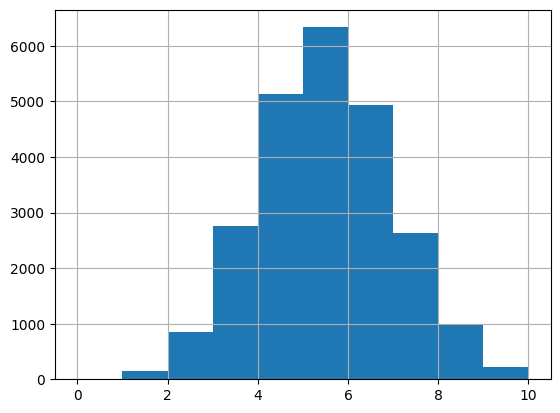

In [ ]:
pd.Series([len(text) for text in X_train_ind]).hist();

In [ ]:
import numpy as np

seq_len = 10

features_train = np.zeros((len(X_train_ind), 1, seq_len), dtype='float32')
for i, text in enumerate(X_train_ind):
    if len(text) <= seq_len:
        zeros = list(np.zeros(seq_len - len(text)))
        new = zeros + text
    else:
        new = text[: seq_len]
    features_train[i, :] = np.array(new)


features_val = np.zeros((len(X_val_ind), 1, seq_len), dtype='float32')
for i, text in enumerate(X_val_ind):
    if len(text) <= seq_len:
        zeros = list(np.zeros(seq_len - len(text)))
        new = zeros + text
    else:
        new = text[: seq_len]
    features_val[i, :] = np.array(new)

features_train

array([[[   0.,    0.,    0., ..., 5431., 3336., 2493.]],

       [[   0.,    0.,    0., ..., 7334., 7495., 7519.]],

       [[   0.,    0.,    0., ..., 4721., 3784.,  887.]],

       ...,

       [[   0.,    0., 3660., ...,  639., 2330., 6440.]],

       [[   0.,    0.,    0., ..., 3979., 4285., 5979.]],

       [[   0.,    0.,    0., ...,  125., 5849., 5960.]]], dtype=float32)

In [ ]:
features_train.shape

(23990, 1, 10)

In [ ]:
X_val_ind[0]

[3420, 3004, 6428, 911, 2732, 7428]

In [ ]:
features_val[0]

array([[   0.,    0.,    0.,    0., 3420., 3004., 6428.,  911., 2732.,
        7428.]], dtype=float32)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_val_le = le.transform(y_val)

classes = le.classes_
y_train_le

array([ 4,  6,  1, ...,  0, 11,  6])

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(features_train), torch.from_numpy(y_train_le))
test_data = TensorDataset(torch.from_numpy(features_val), torch.from_numpy(y_val_le))

In [ ]:
BATCH_SIZE = 128

train_loader = DataLoader(train_data,
                          shuffle=True,
                          batch_size=BATCH_SIZE,
                          drop_last=True)
test_loader = DataLoader(test_data,
                         shuffle=True,
                         batch_size=BATCH_SIZE,
                         drop_last=True)


torch.manual_seed(1)
for data, y in train_loader:
    print(data[0])
    print(classes[y[0]])
    break

tensor([[   0.,    0.,    0., 6711.,  728., 5597., 5814., 4315., 2714.,  915.]])
Из жизни


In [ ]:
data.shape

torch.Size([128, 1, 10])

#### Обучение нейросети

In [ ]:
import matplotlib.pyplot as plt


def plot_learning_curves(history, metric='acc'):
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['test'], label='test')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title(f'Метрика {metric}', fontsize=15)
    plt.plot(history[metric]['train'], label='train')
    plt.plot(history[metric]['test'], label='test')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size, self.layer_size, = hidden_size, layer_size

        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True)

        self.layer = nn.Linear(hidden_size, output_size)


    def forward(self, x):

        hidden_state = torch.zeros(self.layer_size, BATCH_SIZE, self.hidden_size).to(device)
        cell_state = torch.zeros(self.layer_size, BATCH_SIZE, self.hidden_size).to(device)


        output, last_state = self.lstm(x, (hidden_state, cell_state))
        # print(output.shape)
        output = output.squeeze(1)
        # print(output.shape)
        output = self.layer(output)

        return output

In [ ]:
input_size = seq_len
hidden_size = 32
layer_size = 2
output_size = len(classes)

net = LSTM(input_size, hidden_size, layer_size, output_size)
net = net.to(device)
net

LSTM(
  (lstm): LSTM(10, 32, num_layers=2, batch_first=True)
  (layer): Linear(in_features=32, out_features=14, bias=True)
)

In [ ]:
data.shape

torch.Size([128, 1, 10])

In [ ]:
out = net(data.to(device))
out.shape

torch.Size([128, 14])

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import F1Score

def train(model, crit, optim,
          train_loader, test_loader,
          num_epochs=10, plot=False):

    history = {'loss': {'train': [], 'test': []},
               'f1': {'train': [], 'test': []}}

    f1 = F1Score(num_classes=len(classes), average='macro', task='multiclass').to(device)

    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0
        f1s_train = []
        f1s_val = []


        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optim.zero_grad()

            outputs = model(inputs)

            loss = crit(outputs, labels)

            loss.backward()
            optim.step()


            train_loss += np.sum(loss.detach().cpu().numpy())
            _, y_pred = torch.max(outputs, 1)
            f1s_train.append(f1(y_pred, labels).cpu())



        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_loader)
        train_f1 = sum(f1s_train) / len(f1s_train)
        history['loss']['train'].append(train_loss)
        history['f1']['train'].append(train_f1)

        model.train(False)
        # полностью проходим по валидационному датасету
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = crit(outputs, y_batch)
            val_loss += np.sum(loss.detach().cpu().numpy())
            _, y_pred = torch.max(outputs, 1)
            f1s_val.append(f1(y_pred, y_batch).cpu())

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(test_loader)
        val_f1 = sum(f1s_val) / len(f1s_val)

        history['loss']['test'].append(val_loss)
        history['f1']['test'].append(val_f1)

        if epoch % 10 == 0:
          print(f"Epoch {epoch + 1} of {num_epochs}")
          print(f"  train loss: {train_loss:.3f}" \
                f"  test loss: {val_loss:.3f}"  \
                f"  train f1: {train_f1 * 100:.2f}%" \
                f"  test f1: {val_f1 * 100:.2f}%")


    return model, history

Epoch 1 of 100
  train loss: 2.538  test loss: 2.488  train f1: 2.98%  test f1: 2.83%
Epoch 11 of 100
  train loss: 2.469  test loss: 2.477  train f1: 4.72%  test f1: 4.53%
Epoch 21 of 100
  train loss: 2.466  test loss: 2.476  train f1: 5.04%  test f1: 5.27%
Epoch 31 of 100
  train loss: 2.464  test loss: 2.479  train f1: 5.50%  test f1: 5.31%
Epoch 41 of 100
  train loss: 2.463  test loss: 2.476  train f1: 5.34%  test f1: 5.55%
Epoch 51 of 100
  train loss: 2.461  test loss: 2.477  train f1: 5.61%  test f1: 5.12%
Epoch 61 of 100
  train loss: 2.462  test loss: 2.475  train f1: 5.72%  test f1: 5.23%
Epoch 71 of 100
  train loss: 2.462  test loss: 2.477  train f1: 5.62%  test f1: 5.19%
Epoch 81 of 100
  train loss: 2.463  test loss: 2.476  train f1: 5.62%  test f1: 5.55%
Epoch 91 of 100
  train loss: 2.460  test loss: 2.475  train f1: 5.82%  test f1: 5.74%


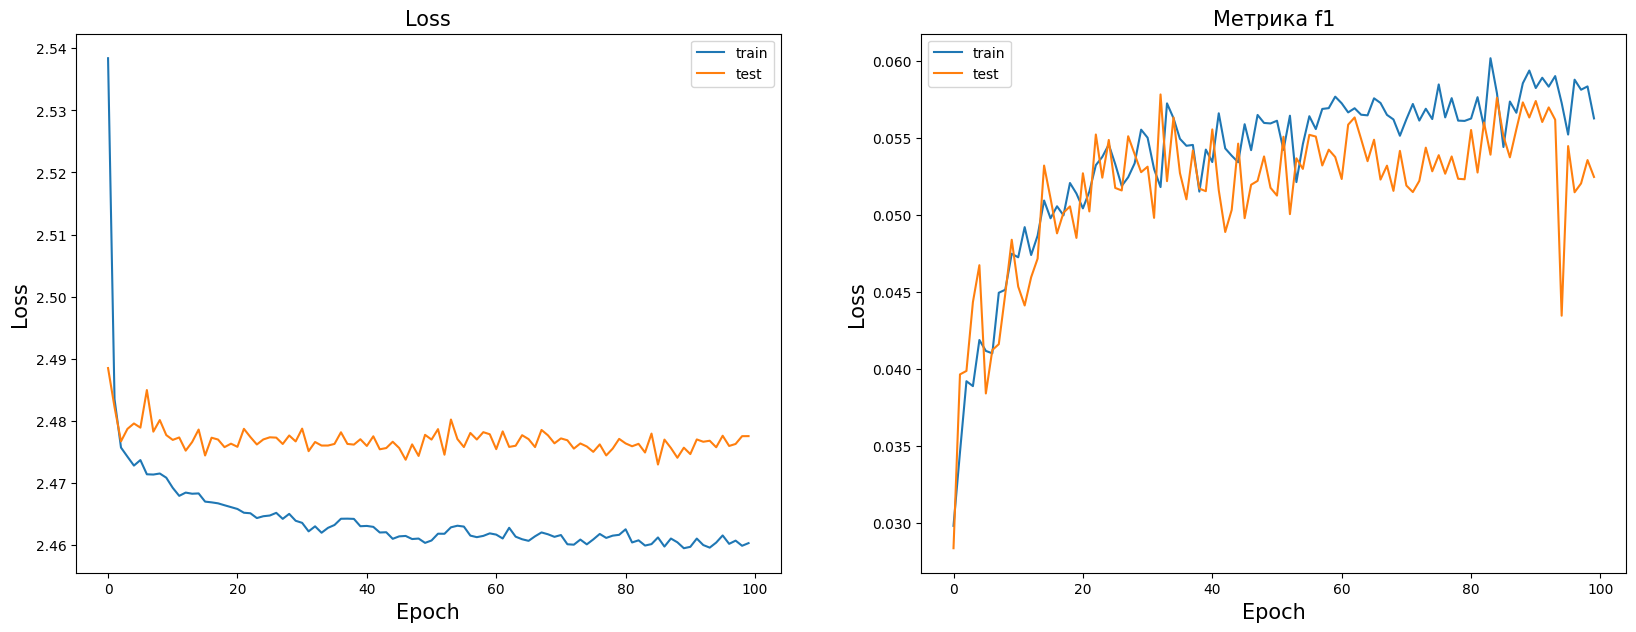

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net, history = train(
    net, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=100,
)

plot_learning_curves(history, 'f1')

### Со слоем эмбеддинга

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim,
                 hidden_size, layer_size,
                 output_size):
        super(LSTM, self).__init__()

        self.hidden_size, self.layer_size, = hidden_size, layer_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_size, layer_size, batch_first=True)

        self.layer = nn.Linear(hidden_size, output_size)


    def forward(self, x, printt=False):

        hidden_state = torch.zeros(self.layer_size, BATCH_SIZE, self.hidden_size).to(device)
        cell_state = torch.zeros(self.layer_size, BATCH_SIZE, self.hidden_size).to(device)

        x = self.embedding(x)
        if printt:
            print(x.shape)

        x = torch.mean(x, 1)
        if printt:
            print(x.shape)

        x = x.unsqueeze(1)
        if printt:
            print(x.shape)

        output, last_state = self.lstm(x, (hidden_state, cell_state))
        output = output.squeeze(1)
        output = self.layer(output)


        return output

In [ ]:
net = LSTM(len(word2id), 100, hidden_size, layer_size, output_size)
net = net.to(device)
net

LSTM(
  (embedding): Embedding(7629, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True)
  (layer): Linear(in_features=32, out_features=14, bias=True)
)

In [ ]:
data.shape

torch.Size([128, 1, 10])

In [ ]:
out = net(data.to(device))
out.shape

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)

In [ ]:
import numpy as np

seq_len = 10

features_train = np.zeros((len(X_train_ind), seq_len), dtype='int')
for i, text in enumerate(X_train_ind):
    if len(text) <= seq_len:
        zeros = list(np.zeros(seq_len - len(text)))
        new = zeros + text
    else:
        new = text[: seq_len]
    features_train[i, :] = np.array(new)


features_val = np.zeros((len(X_val_ind), seq_len), dtype='int')
for i, text in enumerate(X_val_ind):
    if len(text) <= seq_len:
        zeros = list(np.zeros(seq_len - len(text)))
        new = zeros + text
    else:
        new = text[: seq_len]
    features_val[i, :] = np.array(new)

features_train

array([[   0,    0,    0, ..., 5431, 3336, 2493],
       [   0,    0,    0, ..., 7334, 7495, 7519],
       [   0,    0,    0, ..., 4721, 3784,  887],
       ...,
       [   0,    0, 3660, ...,  639, 2330, 6440],
       [   0,    0,    0, ..., 3979, 4285, 5979],
       [   0,    0,    0, ...,  125, 5849, 5960]])

In [ ]:
features_train.shape

(23990, 10)

In [ ]:
X_val_ind[0]

[3420, 3004, 6428, 911, 2732, 7428]

In [ ]:
features_val[0]

array([   0,    0,    0,    0, 3420, 3004, 6428,  911, 2732, 7428])

In [ ]:
train_data = TensorDataset(torch.from_numpy(features_train), torch.from_numpy(y_train_le))
test_data = TensorDataset(torch.from_numpy(features_val), torch.from_numpy(y_val_le))

train_loader = DataLoader(train_data,
                          shuffle=True,
                          batch_size=BATCH_SIZE,
                          drop_last=True)
test_loader = DataLoader(test_data,
                         shuffle=True,
                         batch_size=BATCH_SIZE,
                         drop_last=True)


torch.manual_seed(1)
for data, y in train_loader:
    print(data[0])
    print(classes[y[0]])
    break

tensor([   0,    0,    0, 6711,  728, 5597, 5814, 4315, 2714,  915])
Из жизни


In [ ]:
data.shape

torch.Size([128, 10])

In [ ]:
out = net(data.to(device), printt=True)
out.shape

torch.Size([128, 10, 100])
torch.Size([128, 100])
torch.Size([128, 1, 100])


torch.Size([128, 14])

Epoch 1 of 100
  train loss: 2.517  test loss: 2.476  train f1: 2.37%  test f1: 3.79%
Epoch 11 of 100
  train loss: 0.820  test loss: 1.366  train f1: 68.98%  test f1: 53.45%
Epoch 21 of 100
  train loss: 0.411  test loss: 1.472  train f1: 84.65%  test f1: 58.27%
Epoch 31 of 100
  train loss: 0.232  test loss: 1.736  train f1: 92.87%  test f1: 57.51%
Epoch 41 of 100
  train loss: 0.133  test loss: 2.060  train f1: 96.16%  test f1: 58.03%
Epoch 51 of 100
  train loss: 0.079  test loss: 2.387  train f1: 97.74%  test f1: 57.75%
Epoch 61 of 100
  train loss: 0.049  test loss: 2.706  train f1: 98.54%  test f1: 56.65%
Epoch 71 of 100
  train loss: 0.032  test loss: 2.982  train f1: 99.04%  test f1: 55.33%
Epoch 81 of 100
  train loss: 0.022  test loss: 3.263  train f1: 99.35%  test f1: 55.36%
Epoch 91 of 100
  train loss: 0.019  test loss: 3.457  train f1: 99.29%  test f1: 55.73%


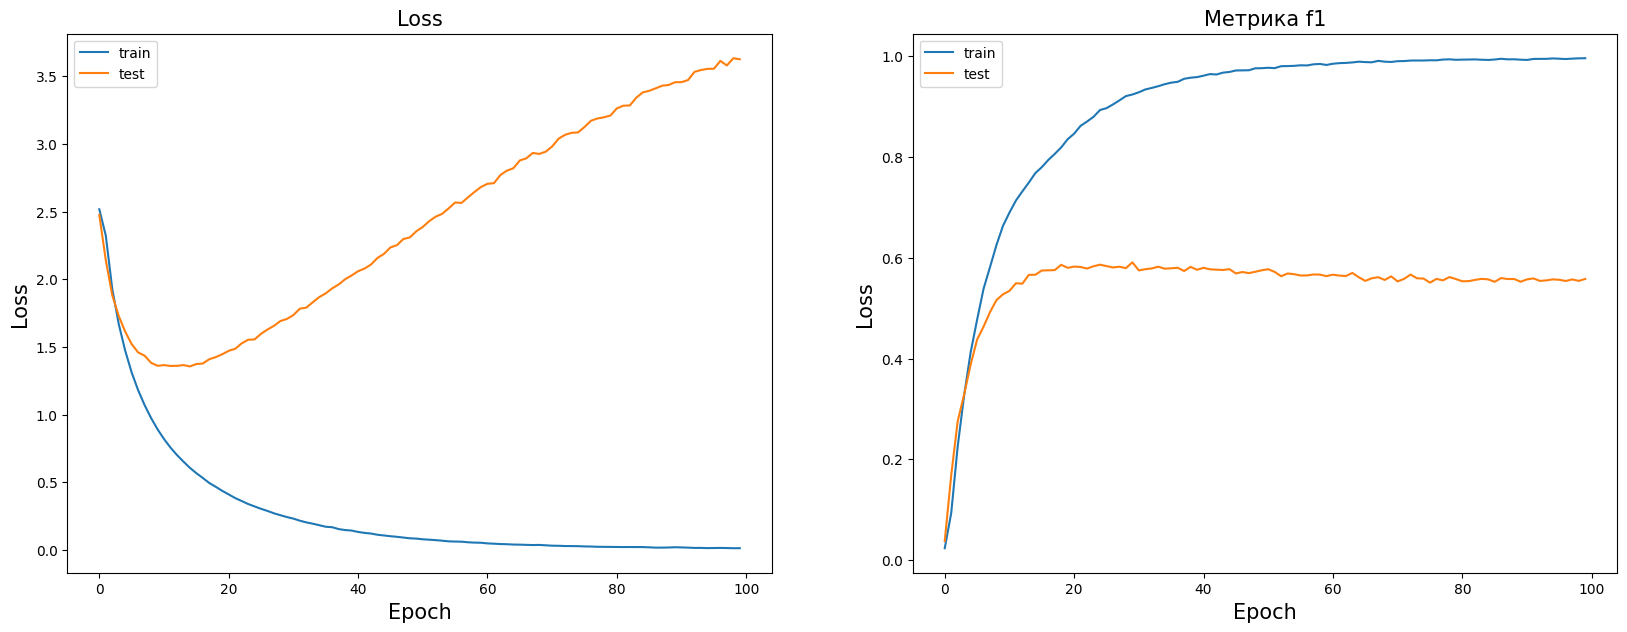

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net, history = train(
    net, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=100,
)

plot_learning_curves(history, 'f1')

#### + Dropout

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim,
                 hidden_size, layer_size,
                 output_size):
        super(LSTM, self).__init__()

        self.hidden_size, self.layer_size, = hidden_size, layer_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_size, layer_size, dropout=0.4, batch_first=True)

        self.layer = nn.Linear(hidden_size, output_size)


    def forward(self, x):


        hidden_state = torch.zeros(self.layer_size, BATCH_SIZE, self.hidden_size).to(device)
        cell_state = torch.zeros(self.layer_size, BATCH_SIZE, self.hidden_size).to(device)

        x = self.embedding(x)
        x = torch.mean(x, 1)
        x = x.unsqueeze(1)

        output, last_state = self.lstm(x, (hidden_state, cell_state))
        output = output.squeeze(1)
        output = self.layer(output)


        return output

In [ ]:
net = LSTM(len(word2id), 50, hidden_size, 1, output_size)
net = net.to(device)
net

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (embedding): Embedding(7629, 50)
  (lstm): LSTM(50, 32, batch_first=True, dropout=0.4)
  (layer): Linear(in_features=32, out_features=14, bias=True)
)

In [ ]:
out = net(data.to(device))
out.shape

torch.Size([128, 14])

Epoch 1 of 50
  train loss: 2.502  test loss: 2.460  train f1: 3.51%  test f1: 4.10%
Epoch 11 of 50
  train loss: 0.927  test loss: 1.270  train f1: 66.16%  test f1: 55.85%
Epoch 21 of 50
  train loss: 0.520  test loss: 1.203  train f1: 80.85%  test f1: 61.36%
Epoch 31 of 50
  train loss: 0.321  test loss: 1.338  train f1: 89.29%  test f1: 61.61%
Epoch 41 of 50
  train loss: 0.201  test loss: 1.551  train f1: 93.69%  test f1: 61.36%


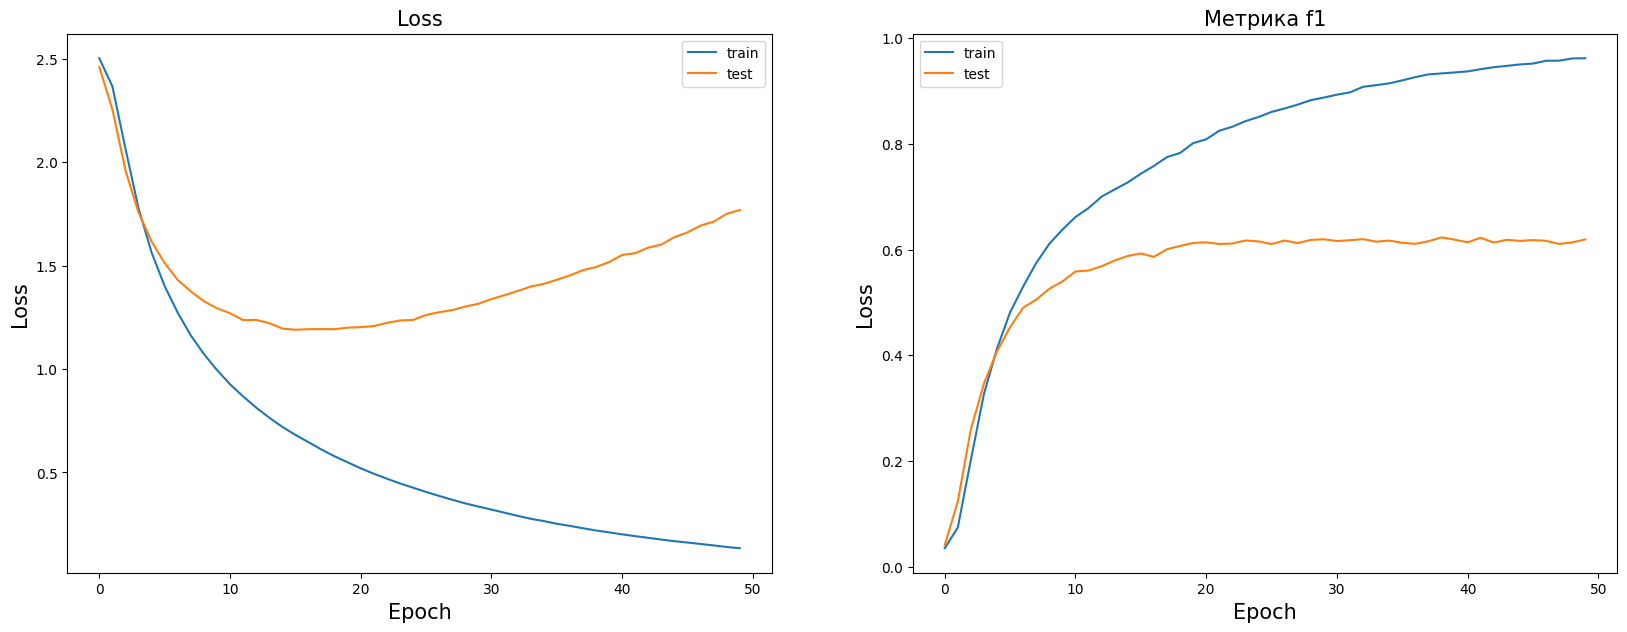

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net, history = train(
    net, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=50,
)

plot_learning_curves(history, 'f1')

## Генерация текста

https://drive.google.com/file/d/1gCISOFoF646FevlwH82a7J6r6JpeCCQk

In [ ]:
!wget 'https://drive.google.com/uc?id=1gCISOFoF646FevlwH82a7J6r6JpeCCQk' -O songdata.csv

--2024-10-21 07:47:00--  https://drive.google.com/uc?id=1gCISOFoF646FevlwH82a7J6r6JpeCCQk
Resolving drive.google.com (drive.google.com)... 172.217.203.102, 172.217.203.113, 172.217.203.139, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1gCISOFoF646FevlwH82a7J6r6JpeCCQk [following]
--2024-10-21 07:47:00--  https://drive.usercontent.google.com/download?id=1gCISOFoF646FevlwH82a7J6r6JpeCCQk
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72436445 (69M) [application/octet-stream]
Saving to: ‘songdata.csv’

songdata.csv        100%[===================>]  69.08M   225MB/s    in 0.3s    

2024-10-21 07:47:06 (225 MB

In [ ]:
import pandas as pd
import numpy as np

path = "songdata.csv"
df = pd.read_csv(path)
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [ ]:
df['artist'].value_counts().sample()

,count
artist,
Roxy Music,64


In [ ]:
data = df[df['artist'] == 'Deep Purple']
data.head()

,artist,song,link,text
3950,Deep Purple,Anya,/d/deep+purple/anya_20038833.html,I'm so far away from everything you know \nYo...
3951,Deep Purple,Back To Back,/d/deep+purple/back+to+back_20692130.html,I read in the news \nThat the average man \n...
3952,Deep Purple,Bad Attitude,/d/deep+purple/bad+attitude_20038850.html,Take a look at \nThese dirty hands \nTake a ...
3953,Deep Purple,Bird Has Flown,/d/deep+purple/bird+has+flown_20038690.html,Oh the beggar on his cornerstone \nCatches pi...
3954,Deep Purple,Black Night,/d/deep+purple/black+night_20038860.html,"Black night is not right, \nI don't feel so b..."


In [ ]:
data['text'].str.cat(sep='\n')

'I\'m so far away from everything you know  \nYour name is carried, carried on the wind  \nOh your ice blue waters Anya, where do they flow?  \nWhere have they been? Ah where have they been?  \nA hidden passion touching a spark  \nFlame of revolution burning wild in your gypsy heart  \nOh your gypsy heart  \nAnya Anya the spirit of freedom  \nAnya Anya ooh Anya  \n  \nThe light of freedom buried deep within your soul  \nAcross the puszta plain to see  \nThe rhapsody of angels refuse to dance alone  \nWhat do they mean? Oh what do they mean?  \nYour jewel flashing across the dark  \nForbidding distance, I love your gypsy heart  \nOh your gypsy heart  \nAnya Anya the spirit of freedom  \nAnya Anya ooh Anya  \n  \nJewel flashing across the dark  \nForbidding distance, I love your gypsy heart  \nOh your gypsy heart  \nAnya Anya the spirit of freedom  \nAnya Anya ooh Anya\n\n\nI read in the news  \nThat the average man  \nIs uplifted five times a day  \nI\'m confused  \nI have to confess  \

In [ ]:
data_text = data['text'].str.cat(sep='\n').lower()

print(data_text[:100])
print('corpus length:', len(data_text))

i'm so far away from everything you know  
your name is carried, carried on the wind  
oh your ice b
corpus length: 176743


In [ ]:
chars = sorted(list(set(data_text)))
print(chars)
print('total chars:', len(chars))

['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '6', '8', '9', ':', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
total chars: 47


In [ ]:
char2int = dict((c, i) for i, c in enumerate(chars))
int2char = dict((i, c) for i, c in enumerate(chars))

print(char2int)

{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '6': 14, '8': 15, '9': 16, ':': 17, '?': 18, '[': 19, ']': 20, 'a': 21, 'b': 22, 'c': 23, 'd': 24, 'e': 25, 'f': 26, 'g': 27, 'h': 28, 'i': 29, 'j': 30, 'k': 31, 'l': 32, 'm': 33, 'n': 34, 'o': 35, 'p': 36, 'q': 37, 'r': 38, 's': 39, 't': 40, 'u': 41, 'v': 42, 'w': 43, 'x': 44, 'y': 45, 'z': 46}


In [ ]:
seq_length = 50
step = 1
sentences = []
next_chars = []

for i in range(0, len(data_text) - seq_length, step):
    sentences.append(data_text[i: i + seq_length])
    next_chars.append(data_text[i + seq_length])

sentences = np.array(sentences)
next_chars = np.array(next_chars)

print(sentences[:5])
print(next_chars[:5])
print('Number of sequences:', len(sentences))

["i'm so far away from everything you know  \nyour na"
 "'m so far away from everything you know  \nyour nam"
 'm so far away from everything you know  \nyour name'
 ' so far away from everything you know  \nyour name '
 'so far away from everything you know  \nyour name i']
['m' 'e' ' ' 'i' 's']
Number of sequences: 176693


In [ ]:
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences), seq_length))
    y = np.zeros((len(sentences)))

    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char2int[char]
        y[i] = char2int[next_chars[i]]
    return X, y

In [ ]:
train_x, train_y = getdata(sentences, next_chars)
print('Shape of train_x:', train_x.shape)
print('Shape of train_y:', train_y.shape)

Shape of train_x: (176693, 50)
Shape of train_y: (176693,)


In [ ]:
sentences[0]

"i'm so far away from everything you know  \nyour na"

In [ ]:
char2int['h'], char2int['e'], char2int['\'']

(28, 25, 4)

In [ ]:
train_x[0], train_y[0]

(array([29.,  4., 33.,  1., 39., 35.,  1., 26., 21., 38.,  1., 21., 43.,
        21., 45.,  1., 26., 38., 35., 33.,  1., 25., 42., 25., 38., 45.,
        40., 28., 29., 34., 27.,  1., 45., 35., 41.,  1., 31., 34., 35.,
        43.,  1.,  1.,  0., 45., 35., 41., 38.,  1., 34., 21.]),
 33.0)

In [ ]:
X_train_tensor = torch.tensor(train_x, dtype=torch.long).to(device)
Y_train_tensor = torch.tensor(train_y, dtype=torch.long).to(device)

In [ ]:
from torch.utils.data import DataLoader

train = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=128)

for data, y in train_loader:
    print(data[0])
    print(y[0])
    break

tensor([29,  4, 33,  1, 39, 35,  1, 26, 21, 38,  1, 21, 43, 21, 45,  1, 26, 38,
        35, 33,  1, 25, 42, 25, 38, 45, 40, 28, 29, 34, 27,  1, 45, 35, 41,  1,
        31, 34, 35, 43,  1,  1,  0, 45, 35, 41, 38,  1, 34, 21],
       device='cuda:0')
tensor(33, device='cuda:0')


### Обучение модели

In [ ]:
class Simple_LSTM(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, dropout=0.2):
        super(Simple_LSTM, self).__init__()
        torch.manual_seed(9)
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout, num_layers=2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)

    def forward(self, seq_in, printt=False):
        embedded = self.embeddings(seq_in)
        if printt:
            print('after emb', embedded.shape)

        lstm_out, _ = self.lstm(embedded)
        if printt:
            print('after lstm', lstm_out.shape)

        ht = lstm_out[:, -1]
        if printt:
            print('after agg', ht.shape)

        out = self.fc(ht)
        return out

In [ ]:
net = Simple_LSTM(len(chars), 128, 64)
net = net.to(device)
net

Simple_LSTM(
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.2)
  (embeddings): Embedding(47, 64)
  (fc): Linear(in_features=128, out_features=47, bias=True)
)

In [ ]:
data.shape

torch.Size([128, 50])

In [ ]:
out = net(data, printt=True)
out.shape

after emb torch.Size([128, 50, 64])
after lstm torch.Size([128, 50, 128])
after agg torch.Size([128, 128])


torch.Size([128, 47])

In [ ]:
def train(model, crit, optim,
          train_loader,
          num_epochs=10,
          plot=False):

    history = {'loss': []}


    for epoch in range(num_epochs):
        train_loss = 0

        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            # print(inputs[0], labels[0])
            optim.zero_grad()

            outputs = model(inputs)

            loss = crit(outputs, labels)

            loss.backward()
            optim.step()

            train_loss += np.sum(loss.detach().cpu().numpy())

        train_loss /= len(train_loader)
        history['loss'].append(train_loss)


        print(f"Epoch {epoch + 1} of {num_epochs}", end='')
        print(f"  train loss: {train_loss:.3f}")


    return model, history

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

net, history = train(
    net, criterion, optimizer,
    train_loader,
    num_epochs=40,
)

Epoch 1 of 40  train loss: 2.101
Epoch 2 of 40  train loss: 1.703
Epoch 3 of 40  train loss: 1.574
Epoch 4 of 40  train loss: 1.492
Epoch 5 of 40  train loss: 1.433
Epoch 6 of 40  train loss: 1.390
Epoch 7 of 40  train loss: 1.353
Epoch 8 of 40  train loss: 1.323
Epoch 9 of 40  train loss: 1.294
Epoch 10 of 40  train loss: 1.271
Epoch 11 of 40  train loss: 1.248
Epoch 12 of 40  train loss: 1.231
Epoch 13 of 40  train loss: 1.214
Epoch 14 of 40  train loss: 1.197
Epoch 15 of 40  train loss: 1.182
Epoch 16 of 40  train loss: 1.169
Epoch 17 of 40  train loss: 1.155
Epoch 18 of 40  train loss: 1.144
Epoch 19 of 40  train loss: 1.131
Epoch 20 of 40  train loss: 1.122
Epoch 21 of 40  train loss: 1.112
Epoch 22 of 40  train loss: 1.105
Epoch 23 of 40  train loss: 1.097
Epoch 24 of 40  train loss: 1.087
Epoch 25 of 40  train loss: 1.080
Epoch 26 of 40  train loss: 1.072
Epoch 27 of 40  train loss: 1.067
Epoch 28 of 40  train loss: 1.059
Epoch 29 of 40  train loss: 1.054
Epoch 30 of 40  train l

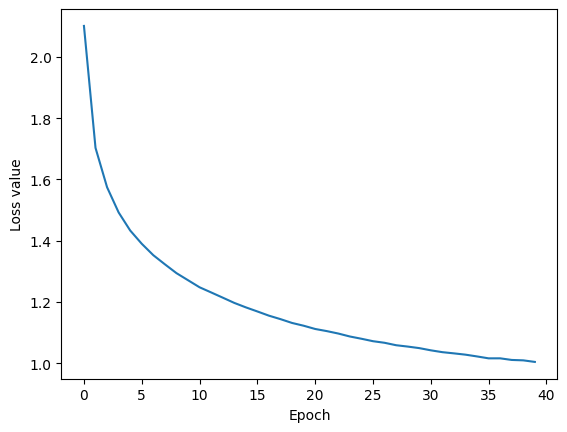

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

### Делаем предсказание

In [ ]:
example = data_text[:50]
example

"i'm so far away from everything you know  \nyour na"

In [ ]:
x = np.zeros((1, seq_length))
for i, char in enumerate(example):
    x[0, i] = char2int[char]

x

array([[29.,  4., 33.,  1., 39., 35.,  1., 26., 21., 38.,  1., 21., 43.,
        21., 45.,  1., 26., 38., 35., 33.,  1., 25., 42., 25., 38., 45.,
        40., 28., 29., 34., 27.,  1., 45., 35., 41.,  1., 31., 34., 35.,
        43.,  1.,  1.,  0., 45., 35., 41., 38.,  1., 34., 21.]])

In [ ]:
train_data = torch.LongTensor(x).to(device)
train_data

tensor([[29,  4, 33,  1, 39, 35,  1, 26, 21, 38,  1, 21, 43, 21, 45,  1, 26, 38,
         35, 33,  1, 25, 42, 25, 38, 45, 40, 28, 29, 34, 27,  1, 45, 35, 41,  1,
         31, 34, 35, 43,  1,  1,  0, 45, 35, 41, 38,  1, 34, 21]],
       device='cuda:0')

In [ ]:
pred = net(train_data)
pred

tensor([[ -4.1122,  -3.6697, -13.6462,  -9.8776,  -5.2584, -10.2210, -11.0943,
          -4.2029,  -6.6314,  -9.2913,  -7.3682, -11.6225, -18.2596,  -9.2776,
          -9.4855, -20.8537, -23.3538, -20.9146,  -7.8873, -12.5569, -11.9087,
          -3.7233,   2.0484,   2.1992,  -0.6157,  -3.3766,   1.2426,   3.4736,
          -6.0698,   0.7374,  -6.8414,  -0.1366,   4.1823,   7.3869,  -0.8006,
          -2.7094,  -0.2235,  -6.9499,   1.0961,   1.3595,   1.8152,  -2.0666,
          -1.0830,  -2.5851,  -3.3456,  -2.9366,  -1.9068]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
pred_char = int2char[torch.argmax(pred).item()]
pred_char

'm'

**Второй символ**

In [ ]:
example = example[1:] + pred_char
example

"'m so far away from everything you know  \nyour nam"

In [ ]:
x = np.zeros((1, seq_length))
for i, char in enumerate(example):
    x[0, i] = char2int[char]

x

array([[ 4., 33.,  1., 39., 35.,  1., 26., 21., 38.,  1., 21., 43., 21.,
        45.,  1., 26., 38., 35., 33.,  1., 25., 42., 25., 38., 45., 40.,
        28., 29., 34., 27.,  1., 45., 35., 41.,  1., 31., 34., 35., 43.,
         1.,  1.,  0., 45., 35., 41., 38.,  1., 34., 21., 33.]])

In [ ]:
train_data = torch.LongTensor(x).to(device)
train_data

tensor([[ 4, 33,  1, 39, 35,  1, 26, 21, 38,  1, 21, 43, 21, 45,  1, 26, 38, 35,
         33,  1, 25, 42, 25, 38, 45, 40, 28, 29, 34, 27,  1, 45, 35, 41,  1, 31,
         34, 35, 43,  1,  1,  0, 45, 35, 41, 38,  1, 34, 21, 33]],
       device='cuda:0')

In [ ]:
pred = net(train_data)[0]
pred

tensor([ -9.3333,  -1.6691,  -1.5100,  -8.0110,  -4.6332, -12.9142,  -9.2454,
         -4.0833,  -7.6464,  -4.6730,  -9.9642, -24.9893, -24.3294, -16.5693,
        -18.4837, -21.0162, -14.9739, -29.6501,  -5.9066, -24.5123, -10.2371,
          0.8997,   0.2257,  -5.6440,  -7.3414,   8.3173,  -3.8630,  -4.4187,
         -4.4638,   1.0020, -11.3175,  -5.8413,  -1.0104,   1.2758,  -3.5145,
          4.1294,  -3.7036,  -9.2990,  -0.8775,  -1.1433,  -2.0503,   1.2276,
         -2.1693,  -6.7699,  -8.9684,  -2.7459,  -2.5440], device='cuda:0',
       grad_fn=<SelectBackward0>)

Температура — это параметр, используемый в моделях генерации текста, который управляет случайностью и креативностью результатов.

1. **Низкая температура (например, 0.1 - 0.3)** - Модель будет более предсказуемой

2. **Средняя температура (например, 0.4 - 0.7)** - Модель будет находить баланс между креативностью и предсказуемостью


3. **Высокая температура (например, 0.8 и выше)** - Модель будет более случайной и креативной.


In [ ]:
# Применяем температуру к вероятностям
temperature = 0.25
adjusted_probs = nn.Softmax()(pred / temperature).cpu().detach().numpy()
adjusted_probs /= np.sum(adjusted_probs)  # Нормализация

adjusted_probs

array([2.17677198e-31, 4.48626658e-18, 8.47830680e-18, 4.31422782e-29,
       3.18238448e-23, 1.30971049e-37, 3.09334442e-31, 2.87058582e-22,
       1.85479825e-28, 2.71403303e-23, 1.74506559e-32, 0.00000000e+00,
       0.00000000e+00, 5.88545355e-44, 0.00000000e+00, 0.00000000e+00,
       3.46050656e-41, 0.00000000e+00, 1.95224191e-25, 0.00000000e+00,
       5.85885523e-33, 1.30100981e-13, 8.78024612e-15, 5.58154638e-25,
       6.28150381e-28, 1.00000000e+00, 6.92891697e-22, 7.50581588e-23,
       6.26479189e-23, 1.95901645e-13, 7.77878795e-35, 2.53570611e-25,
       6.25318368e-17, 5.85834495e-13, 2.79330714e-21, 5.30672892e-08,
       1.31081086e-21, 2.49718587e-31, 1.06435586e-16, 3.67574844e-17,
       9.76386521e-19, 4.83063947e-13, 6.06698619e-19, 6.17933390e-27,
       9.36743549e-31, 6.04282321e-20, 1.35529847e-19], dtype=float32)

In [ ]:
# Генерируем символ на основе скорректированных вероятностей
char_int = np.random.choice(range(len(pred)), p=adjusted_probs)
int2char[char_int]

'e'

In [ ]:
def sample(preds, temperature=1.0):
    adjusted_probs = nn.Softmax()(pred / temperature).cpu().detach().numpy()
    adjusted_probs /= np.sum(adjusted_probs)  # Нормализация
    char_int = np.random.choice(range(len(pred)), p=adjusted_probs)
    return char_int

In [ ]:
from torch.nn import functional as F
from torch.autograd import Variable

sentence = 'i read in the news\nthat the average man\nplease kis'

variance = 0.25
generated = ''
original = sentence
window = sentence

for i in range(400):
    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = char2int[char]

    x_in = torch.LongTensor(x).cuda()
    pred = net(x_in)[0]
    next_index = sample(pred, variance)
    next_char = int2char[next_index]

    generated += next_char
    window = window[1:] + next_char

print(original + generated)

i read in the news
that the average man
please kiss here that's a friend of the station  
i was no one cared  
  
i can't take it anymore...  
  
sail away for drignd  
  
i was a thing i can't remembe  
we can't stand the words with the walls  
  
i want to be me onder  
waiting for the same  
  
i can't see my woman to feel you  
one man's leave a place to the car  
when i was a funny for the same  
i can't take to the crying think  
  
you kno


## Машинный перевод Seq2Seq

In [ ]:
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget 'https://drive.google.com/uc?id=1ZtlIS-XGfnaMSTtjRgRtB0DJkctSOaLY' -O eng-fra.txt

--2024-10-22 09:57:56--  https://drive.google.com/uc?id=1ZtlIS-XGfnaMSTtjRgRtB0DJkctSOaLY
Resolving drive.google.com (drive.google.com)... 142.250.4.113, 142.250.4.101, 142.250.4.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.4.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1ZtlIS-XGfnaMSTtjRgRtB0DJkctSOaLY [following]
--2024-10-22 09:57:57--  https://drive.usercontent.google.com/download?id=1ZtlIS-XGfnaMSTtjRgRtB0DJkctSOaLY
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.68.132, 2404:6800:4003:c1c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.68.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9541158 (9.1M) [application/octet-stream]
Saving to: ‘eng-fra.txt’

eng-fra.txt         100%[===================>]   9.10M  26.1MB/s    in 0.3s    

2024-10-22 09:58:03 (26.1 MB/s) - ‘eng-f

In [ ]:
!tail data/eng-fra.txt

tail: cannot open 'data/eng-fra.txt' for reading: No such file or directory


In [ ]:
lines = open('eng-fra.txt', encoding='utf-8').read().strip().split('\n')
lines[:10]

['Go.\tVa !',
 'Run!\tCours\u202f!',
 'Run!\tCourez\u202f!',
 'Wow!\tÇa alors\u202f!',
 'Fire!\tAu feu !',
 "Help!\tÀ l'aide\u202f!",
 'Jump.\tSaute.',
 'Stop!\tÇa suffit\u202f!',
 'Stop!\tStop\u202f!',
 'Stop!\tArrête-toi !']

In [ ]:
def normalizeString(s):
    s = re.sub(r"[^a-zA-Z.!? ]", r"", s.lower().strip())
    return s

In [ ]:
list_pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
list_pairs[:5]

[['go.', 'va !'],
 ['run!', 'cours!'],
 ['run!', 'courez!'],
 ['wow!', 'a alors!'],
 ['fire!', 'au feu !']]

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
input_lang = Lang('eng')
output_lang = Lang('fra')

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
           len(p[1].split(' ')) < MAX_LENGTH and \
           p[0].startswith(eng_prefixes)

In [ ]:
pairs = [pair for pair in list_pairs if filterPair(pair)]

for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])

print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)

eng 2235
fra 3026


In [ ]:
print(random.choice(pairs))

['he isnt at home.', 'il nest pas  la maison.']


In [ ]:
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
training_pairs = tensorsFromPair(random.choice(pairs))
training_pairs

(tensor([[ 31],
         [  6],
         [ 19],
         [521],
         [  1]], device='cuda:0'),
 tensor([[ 87],
         [ 33],
         [747],
         [ 26],
         [748],
         [  1]], device='cuda:0'))

### Encoder




In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size)

    def forward(self, input, hidden, printt=False):
        embedded = self.embedding(input).view(1, 1, -1)
        if printt:
            print('ebedding', embedded.shape)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
training_pairs[0].shape

torch.Size([5, 1])

In [ ]:
net = EncoderRNN(input_lang.n_words, 100, 64).to(device)
hidden = net.initHidden()

for i in range(training_pairs[0].size(0)):
    out, hidden = net(training_pairs[0][i], hidden, printt=True)
    print('out', out.shape)

ebedding torch.Size([1, 1, 100])
out torch.Size([1, 1, 64])
ebedding torch.Size([1, 1, 100])
out torch.Size([1, 1, 64])
ebedding torch.Size([1, 1, 100])
out torch.Size([1, 1, 64])
ebedding torch.Size([1, 1, 100])
out torch.Size([1, 1, 64])
ebedding torch.Size([1, 1, 100])
out torch.Size([1, 1, 64])


### Decoder



In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_dim, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, printt=False):
        output = self.embedding(input).view(1, 1, -1)
        if printt:
            print('after embedding', output.shape)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        if printt:
            print('after gru', output.shape)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
decoder_input = torch.tensor([[SOS_token]], device=device)
decoder_input

tensor([[0]], device='cuda:0')

In [ ]:
decoder_input[0]

tensor([0], device='cuda:0')

In [ ]:
net = DecoderRNN(64, 100, output_lang.n_words).to(device)
hidden_decoder = hidden

out, hidden = net(decoder_input[0], hidden, printt=True)
print('out', out.shape)

after embedding torch.Size([1, 1, 100])
after gru torch.Size([1, 1, 64])
out torch.Size([1, 1, 3026])


In [ ]:
net = DecoderRNN(64, 100, output_lang.n_words).to(device)
hidden_decoder = hidden

for i in range(training_pairs[1].size(0)):
    out, hidden = net(decoder_input[i], hidden)
    print('out', out.shape)
    decoder_input = training_pairs[1]

out torch.Size([1, 1, 3026])
out torch.Size([1, 1, 3026])
out torch.Size([1, 1, 3026])
out torch.Size([1, 1, 3026])
out torch.Size([1, 1, 3026])
out torch.Size([1, 1, 3026])


In [ ]:
val, ind = out.topk(1)
ind[0].item()

0

In [ ]:
output_lang.index2word[ind[0].item()]

'SOS'

### Обучение нейросети

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor,
          encoder, decoder,
          encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top_ind = decoder_output.topk(1)
            decoder_input = top_ind.squeeze()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'


def timeSince(since, percent):
    now = time.time()
    sec = now - since
    es = sec / percent
    left_sec = es - sec
    return f'{asMinutes(sec)} (-{asMinutes(left_sec)})'

In [ ]:
def trainIters(encoder, decoder,
               n_epochs, print_every=1000,
               learning_rate=0.01):

    start = time.time()
    print_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_epochs)]
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs+1):
        training_pair = training_pairs[epoch-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor,
                     encoder, decoder,
                     encoder_optimizer, decoder_optimizer,
                     criterion)

        print_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{timeSince(start, (epoch) / (n_epochs))}' \
                  f'({epoch} {epoch / n_epochs * 100:.3f}%) ' \
                  f'| loss {print_loss_avg:.4f}' )

In [ ]:
hidden_size = 256
embedding_dim = 100
encoder1 = EncoderRNN(input_lang.n_words, embedding_dim, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, embedding_dim, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 75000, print_every=5000)

1m 16s (-17m 41s)(5000 6.667%) | loss 3.8799
2m 28s (-15m 60s)(10000 13.333%) | loss 3.4995
3m 43s (-14m 51s)(15000 20.000%) | loss 3.0842
4m 53s (-13m 27s)(20000 26.667%) | loss 2.6157
6m 5s (-12m 9s)(25000 33.333%) | loss 2.1902
7m 17s (-10m 56s)(30000 40.000%) | loss 1.7436
8m 29s (-9m 42s)(35000 46.667%) | loss 1.3615
9m 41s (-8m 28s)(40000 53.333%) | loss 1.0467
10m 57s (-7m 18s)(45000 60.000%) | loss 0.8293
12m 12s (-6m 6s)(50000 66.667%) | loss 0.6553
13m 25s (-4m 53s)(55000 73.333%) | loss 0.5119
14m 38s (-3m 39s)(60000 80.000%) | loss 0.4154
15m 50s (-2m 26s)(65000 86.667%) | loss 0.3616
17m 4s (-1m 13s)(70000 93.333%) | loss 0.3321
18m 19s (-0m 0s)(75000 100.000%) | loss 0.3007


### Предсказания

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top_ind = decoder_output.data.topk(1)
            if top_ind.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[top_ind.item()])

            decoder_input = top_ind.squeeze()

        return decoded_words

In [ ]:
def evaluateRandomly(encoder, decoder, n=5):
    for i in range(n):
        pair = random.choice(pairs)
        print('true input:', pair[0])
        print('true output:', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('pred output:', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder1, decoder1)

true input: he is lying on the sofa.
true output: il est allong sur le canap.
pred output: il est tendu sur le canap. <EOS>

true input: she stopped talking.
true output: elle arrta de parler.
pred output: elle a arrt de parler. <EOS>

true input: she is a wonderful woman.
true output: cest une femme magnifique.
pred output: cest une femme tranquille. <EOS>

true input: you are such a liar!
true output: tu es un de ces menteurs !
pred output: vous tes un de ces menteurs ! <EOS>

true input: he is taller than his brother.
true output: il est plus grand que son frre.
pred output: il est plus grand que son frre. <EOS>

